This notebook was created for the study of a galaxy Seyfert Type II.

In [1]:
from astro_constants import *
from source_parameters import *
from rates import *

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy import units as u
from astropy import constants as const
from scipy.stats import chisquare
from scipy.optimize import curve_fit

Defining our source

In [3]:
## Initialize the class
coronal_data = Coronal_Description(r_x, l, l_x, mdot, m)

## Calculate parameters for emission region
B_c = coronal_data.coronal_mag_field()
n_c = coronal_data.coronal_density()
T_c = coronal_data.coronal_temperature()
delta_RX = coronal_data.width_current_sheet()
wdot_B = coronal_data.mag_rec_power()

print(f'\nCoronal Magnetic Field:\n B_c = {B_c:.4E} G')
print(f'\nCoronal Particle Number Density:\n n_c = {n_c:.4E} cm-3')
print(f'\nCoronal Temperature:\n T_c = {T_c:.4E} K')
print(f'\nWidth of the current sheet:\n delta_RX = {delta_RX:.4E} cm')
print(f'\nReconnection Power:\n wdot_B = {wdot_B:.4E} erg s-1')


Coronal Magnetic Field:
 B_c = 1.0478E+04 G

Coronal Particle Number Density:
 n_c = 3.4392E+10 cm-3

Coronal Temperature:
 T_c = 2.5282E+09 K

Width of the current sheet:
 delta_RX = 1.6649E+11 cm

Reconnection Power:
 wdot_B = 5.9912E+42 erg s-1


In [4]:
# Load the data from the CSV files
archival_data = pd.read_csv('observed_SED/archival_data.csv', header=None)
magic_data = pd.read_csv('observed_SED/4FGL_MAGIC_data.csv', header=None)
icecube_data = pd.read_csv('observed_SED/IceCube_neutrinos_data.csv', header=None)

In [5]:
magic_data

,0,1
0,0.070006,6.951928e-13
1,0.176924,9.131168e-13
2,0.553813,9.701572e-13
3,1.733557,5.292784e-13
4,5.426418,2.717756e-13
5,16.985897,5.292784e-13
6,94.070040,4.029611e-13
7,94.070040,2.266017e-13
8,316.227766,1.095150e-12
9,316.227766,6.158482e-13


In [6]:
# Remove the rows with indices 7, 9, 11, 13, and 15
indices_to_remove = [7, 9, 11, 13, 15]
magic_data_cleaned = magic_data.drop(indices_to_remove, axis=0).reset_index(drop=True)

# Use .iloc for positional indexing
data_4FGL_DR2 = magic_data_cleaned.iloc[:7]  # First 7 points
data_MAGIC = magic_data_cleaned.iloc[7:]     # Remaining points

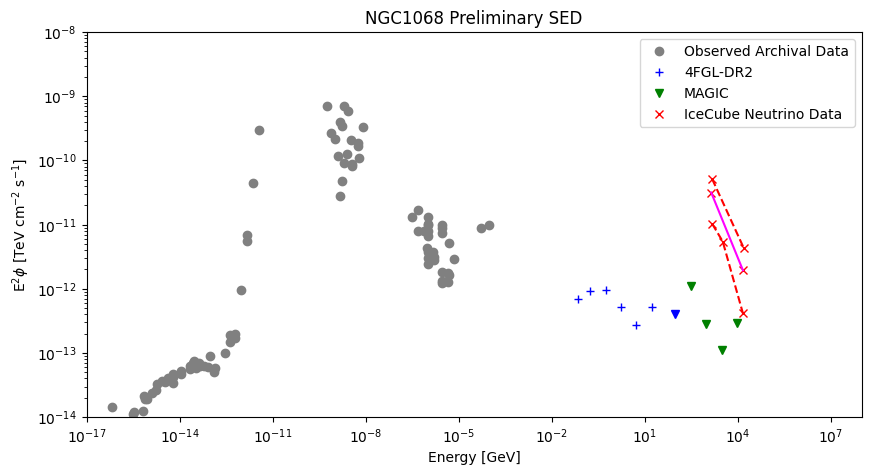

In [7]:
plt.figure(figsize=(10, 5))

## Archival data
plt.plot(archival_data[0], archival_data[1], 'o', label='Observed Archival Data', color='gray')

## 4FGL & MAGIC data
# plt.plot(magic_data[0], magic_data[1], 's', label='4FGL & MAGIC Data', color='green')

## Plot the first 6 points with '+'
plt.plot(data_4FGL_DR2.iloc[:6, 0], data_4FGL_DR2.iloc[:6, 1], '+', label='4FGL-DR2', color='blue')

## Plot the 7th point with 'v'
plt.plot(data_4FGL_DR2.iloc[6, 0], data_4FGL_DR2.iloc[6, 1], 'v', color='blue')

## Plot the remaining points with 'v' in a different color
plt.plot(data_MAGIC.iloc[:, 0], data_MAGIC.iloc[:, 1], 'v', label='MAGIC', color='green')

## IceCube Neutrino data
plt.plot(icecube_data[0], icecube_data[1], 'x', label='IceCube Neutrino Data', color='red')
plt.plot(icecube_data[0][0:2], icecube_data[1][0:2], '--', color='red')
plt.plot(icecube_data[0][2:4], icecube_data[1][2:4], '-', color='magenta')
plt.plot(icecube_data[0][4:7], icecube_data[1][4:7], '--', color='red')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-17, 1e8)
plt.ylim(1e-14, 1e-8)
plt.xlabel('Energy [GeV]')
plt.ylabel(r'E$^2 \phi$ [TeV cm$^{-2}$ s$^{-1}$]')
plt.title('NGC1068 Preliminary SED')

plt.legend()

plt.savefig('plots/preliminary_SED.png',dpi=300)

plt.show()


Parâmetros ajustados:
Normalização: 6.622e-12 erg/cm²/s
Alpha (índice): -0.224
Beta (cutoff): 1.000


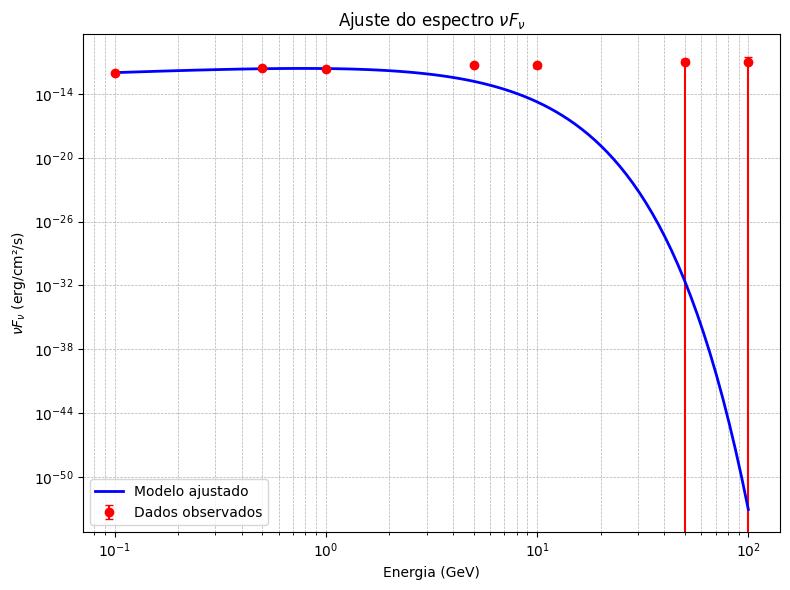

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Dados de exemplo: energia (GeV) e fluxo observado (nu F_nu)
energy_obs = np.array([0.1, 0.5, 1, 5, 10, 50, 100])  # GeV
flux_obs = np.array([1e-11, 5e-12, 2e-12, 1e-12, 5e-13, 2e-13, 1e-13])  # erg/cm²/s
flux_err = np.array([0.2e-12] * len(flux_obs))  # erro associado ao fluxo

# Modelo teórico de F_nu (ajustável via parâmetros)
def model_flux(energy, params):
    # Parâmetros: [normalization, alpha, beta]
    norm, alpha, beta = params
    return norm * energy**alpha * np.exp(-beta * energy)

# Função de custo: calcula o chi^2
def chi_squared(params):
    model = model_flux(energy_obs, params)
    chi2 = np.sum(((flux_obs - model) / flux_err) ** 2)
    return chi2

# Limites dos parâmetros para o Differential Evolution
bounds = [
    (1e-13, 1e-10),  # Normalization [erg/cm²/s]
    (-3, 0),         # Alpha (slope)
    (0.01, 1)        # Beta (exponential cutoff)
]

# Ajuste usando Differential Evolution
result = differential_evolution(chi_squared, bounds, strategy='best1bin', tol=1e-6)
best_params = result.x

# Parâmetros ajustados
print("Parâmetros ajustados:")
print(f"Normalização: {best_params[0]:.3e} erg/cm²/s")
print(f"Alpha (índice): {best_params[1]:.3f}")
print(f"Beta (cutoff): {best_params[2]:.3f}")

# Calcular o modelo ajustado em uma faixa de energias
energy_model = np.logspace(-1, 2, 100)  # GeV
flux_model = model_flux(energy_model, best_params)

# Plotar os dados e o ajuste
plt.figure(figsize=(8, 6))
plt.errorbar(energy_obs, energy_obs * flux_obs, yerr=energy_obs * flux_err,
             fmt='o', label="Dados observados", color='red', capsize=3)
plt.plot(energy_model, energy_model * flux_model, label="Modelo ajustado", color='blue', lw=2)

# Configurações do gráfico
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Energia (GeV)")
plt.ylabel(r"$\nu F_\nu$ (erg/cm²/s)")
plt.title(r"Ajuste do espectro $\nu F_\nu$")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


Parâmetros ajustados:
Normalização: 3.119e-12 erg/cm²/s
Alpha (índice): -0.513
Beta (cutoff): 0.087
Número de gerações: 49


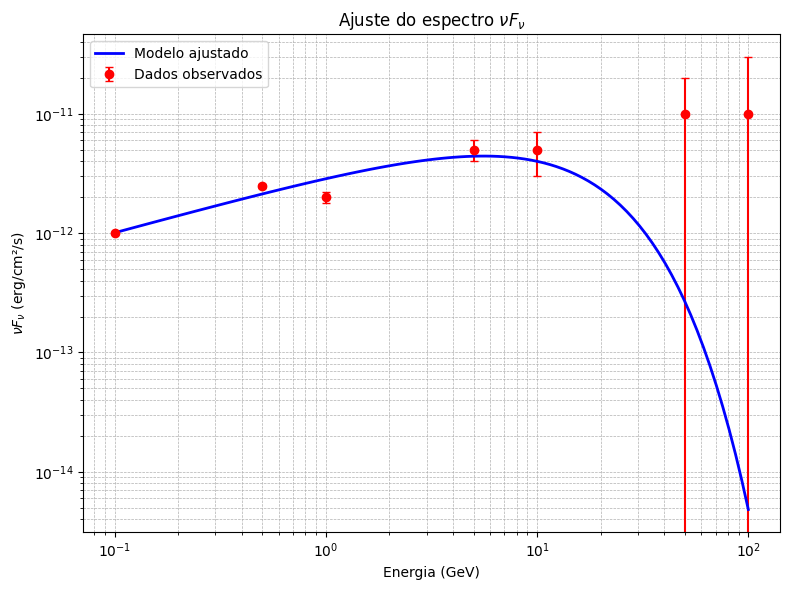

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Dados de exemplo: energia (GeV) e fluxo observado (nu F_nu)
energy_obs = np.array([0.1, 0.5, 1, 5, 10, 50, 100])  # GeV
flux_obs = np.array([1e-11, 5e-12, 2e-12, 1e-12, 5e-13, 2e-13, 1e-13])  # erg/cm²/s
flux_err = np.array([0.2e-12] * len(flux_obs))  # erro associado ao fluxo

# Modelo teórico de F_nu (ajustável via parâmetros)
def model_flux(energy, params):
    # Parâmetros: [normalization, alpha, beta]
    norm, alpha, beta = params
    return norm * energy**alpha * np.exp(-beta * energy)

# Função de custo: calcula o chi^2
def chi_squared(params):
    model = model_flux(energy_obs, params)
    chi2 = np.sum(((flux_obs - model) / flux_err) ** 2)
    return chi2

# Limites dos parâmetros para o Differential Evolution
bounds = [
    (1e-13, 1e-10),  # Normalization [erg/cm²/s]
    (-3, 0),         # Alpha (slope)
    (0.01, 1)        # Beta (exponential cutoff)
]

# Ajuste usando Differential Evolution
result = differential_evolution(chi_squared, bounds, strategy='best1bin', tol=1e-6)
best_params = result.x
n_iterations = result.nit  # Número de gerações

# Parâmetros ajustados
print("Parâmetros ajustados:")
print(f"Normalização: {best_params[0]:.3e} erg/cm²/s")
print(f"Alpha (índice): {best_params[1]:.3f}")
print(f"Beta (cutoff): {best_params[2]:.3f}")
print(f"Número de gerações: {n_iterations}")

# Calcular o modelo ajustado em uma faixa de energias
energy_model = np.logspace(-1, 2, 100)  # GeV
flux_model = model_flux(energy_model, best_params)

# Plotar os dados e o ajuste
plt.figure(figsize=(8, 6))
plt.errorbar(energy_obs, energy_obs * flux_obs, yerr=energy_obs * flux_err,
             fmt='o', label="Dados observados", color='red', capsize=3)
plt.plot(energy_model, energy_model * flux_model, label="Modelo ajustado", color='blue', lw=2)

# Configurações do gráfico
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Energia (GeV)")
plt.ylabel(r"$\nu F_\nu$ (erg/cm²/s)")
plt.title(r"Ajuste do espectro $\nu F_\nu$")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import naima
import matplotlib.pyplot as plt

# Define the particle distribution: A power-law spectrum for this example
particle_distribution = naima.models.PowerLaw(
    amplitude=1e36,  # normalization in particles/energy (e.g., erg^-1)
    e_0=1 * u.TeV,  # reference energy
    alpha=2.2,  # spectral index
    e_min=1 * u.GeV,  # minimum energy
    e_max=100 * u.TeV  # maximum energy
)

# Synchrotron radiation
magnetic_field = 10 * u.uG  # Magnetic field strength
synch_model = naima.radiative.Synchrotron(particle_distribution, B=magnetic_field)

# Bremsstrahlung
target_density = 1 * u.cm**-3  # Target density for bremsstrahlung
bremss_model = naima.radiative.Bremsstrahlung(particle_distribution, n_H=target_density)

# Inverse Compton scattering
# Assume a seed photon field (e.g., CMB or dust photons)
seed_photon_density = 0.25 * u.eV / u.cm**3  # eV/cm³
seed_photon_temperature = 2.7 * u.K  # Temperature for CMB
ic_model = naima.radiative.InverseCompton(
    particle_distribution,
    seed_photon_fields=["CMB"],  # Cosmic Microwave Background
    Eseed=seed_photon_density,
    Tseed=seed_photon_temperature,
)

# Proton-proton interactions
pp_model = naima.models.PionDecay(
    particle_distribution,
    nh=target_density,  # Target hydrogen density
)

# Photon-proton interactions (photo-meson production)
# Specify the photon field for interactions (e.g., synchrotron photons)
photon_energy_density = 0.1 * u.eV / u.cm**3
photon_field_temperature = 5000 * u.K  # Effective temperature
photon_target = naima.models.BlackBody(
    T=photon_field_temperature,
    energy_density=photon_energy_density,
)
photop_model = naima.models.PhotoPionProduction(
    particle_distribution,
    target_photon_spectrum=photon_target,
)

# Compute acceleration rates
energy = np.logspace(9, 15, 100) * u.eV  # Energies from 1 GeV to 1 PeV
synch_rate = synch_model.sed(energy)
bremss_rate = bremss_model.sed(energy)
ic_rate = ic_model.sed(energy)
pp_rate = pp_model.sed(energy)
photop_rate = photop_model.sed(energy)

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(energy, synch_rate, label="Synchrotron", color="blue")
plt.loglog(energy, bremss_rate, label="Bremsstrahlung", color="green")
plt.loglog(energy, ic_rate, label="Inverse Compton", color="red")
plt.loglog(energy, pp_rate, label="Proton-Proton", color="orange")
plt.loglog(energy, photop_rate, label="Photo-Meson", color="purple")

plt.xlabel("Energy (eV)")
plt.ylabel("Acceleration Rate (erg/s)")
plt.title("Acceleration Rates for Different Processes")
plt.legend()
plt.grid(which="both", alpha=0.3)
plt.show()


TypeError: __init__() got an unexpected keyword argument 'e_min'

In [7]:
import numpy as np
import naima
import astropy.units as u
import matplotlib.pyplot as plt

# Define the particle distribution: A power-law spectrum
particle_distribution = naima.models.PowerLaw(
    amplitude=1e36,  # normalization in particles/energy (e.g., erg^-1)
    e_0=1 * u.TeV,  # reference energy
    alpha=2.2,  # spectral index
    e_min=1 * u.GeV,  # minimum energy
    e_max=100 * u.TeV  # maximum energy
)

# Synchrotron radiation
magnetic_field = 10 * u.uG  # Magnetic field strength
synch_model = naima.radiative.Synchrotron(particle_distribution, B=magnetic_field)

# Bremsstrahlung
target_density = 1 * u.cm**-3  # Target density for bremsstrahlung
bremss_model = naima.radiative.Bremsstrahlung(particle_distribution, n_H=target_density)

# Inverse Compton scattering
ic_model = naima.radiative.InverseCompton(
    particle_distribution,
    seed_photon_fields=["CMB"],  # Cosmic Microwave Background
)

# Proton-proton interactions
pp_model = naima.models.PionDecay(
    particle_distribution,
    nh=target_density,  # Target hydrogen density
)

# Photon-proton interactions (photo-meson production)
photon_energy_density = 0.1 * u.eV / u.cm**3
photon_field_temperature = 5000 * u.K  # Effective temperature
photon_target = naima.models.BlackBody(
    T=photon_field_temperature,
    energy_density=photon_energy_density,
)
photop_model = naima.models.PhotoPionProduction(
    particle_distribution,
    target_photon_spectrum=photon_target,
)

# Photon energy range for SED
photon_energy = np.logspace(-3, 3, 100) * u.eV  # From meV to keV

# Compute SEDs
synch_sed = synch_model.sed(photon_energy)
bremss_sed = bremss_model.sed(photon_energy)
ic_sed = ic_model.sed(photon_energy)
pp_sed = pp_model.sed(photon_energy)
photop_sed = photop_model.sed(photon_energy)

# Plotting SED
plt.figure(figsize=(10, 6))
plt.loglog(photon_energy, synch_sed, label="Synchrotron", color="blue")
plt.loglog(photon_energy, bremss_sed, label="Bremsstrahlung", color="green")
plt.loglog(photon_energy, ic_sed, label="Inverse Compton", color="red")
plt.loglog(photon_energy, pp_sed, label="Proton-Proton", color="orange")
plt.loglog(photon_energy, photop_sed, label="Photo-Meson", color="purple")

plt.xlabel("Photon Energy (eV)")
plt.ylabel("SED (erg/cm²/s)")
plt.title("Spectral Energy Distribution (SED) for Various Processes")
plt.legend()
plt.grid(which="both", alpha=0.3)
plt.show()

# Energy range for acceleration rates
energy = np.logspace(9, 15, 100) * u.eV  # Energies from 1 GeV to 1 PeV

# Compute acceleration rates
synch_rate = synch_model.sed(energy)
bremss_rate = bremss_model.sed(energy)
ic_rate = ic_model.sed(energy)
pp_rate = pp_model.sed(energy)
photop_rate = photop_model.sed(energy)

# Plotting acceleration rates
plt.figure(figsize=(10, 6))
plt.loglog(energy, synch_rate, label="Synchrotron", color="blue")
plt.loglog(energy, bremss_rate, label="Bremsstrahlung", color="green")
plt.loglog(energy, ic_rate, label="Inverse Compton", color="red")
plt.loglog(energy, pp_rate, label="Proton-Proton", color="orange")
plt.loglog(energy, photop_rate, label="Photo-Meson", color="purple")

plt.xlabel("Energy (eV)")
plt.ylabel("Acceleration Rate (erg/s)")
plt.title("Acceleration Rates for Different Processes")
plt.legend()
plt.grid(which="both", alpha=0.3)
plt.show()


TypeError: __init__() got an unexpected keyword argument 'e_min'

In [8]:
import numpy as np
import naima
import astropy.units as u
import matplotlib.pyplot as plt

# Define the particle distribution: A power-law spectrum
particle_distribution = naima.models.PowerLaw(
    amplitude=1e36 * u.Unit("1/eV"),  # normalization in particles/energy
    e_0=1 * u.TeV,  # reference energy
    alpha=2.2  # spectral index
)

# Set energy bounds (e_min and e_max)
particle_distribution.set_energy_bounds(1 * u.GeV, 100 * u.TeV)

# Synchrotron radiation
magnetic_field = 10 * u.uG  # Magnetic field strength
synch_model = naima.radiative.Synchrotron(particle_distribution, B=magnetic_field)

# Bremsstrahlung
target_density = 1 * u.cm**-3  # Target density for bremsstrahlung
bremss_model = naima.radiative.Bremsstrahlung(particle_distribution, n_H=target_density)

# Inverse Compton scattering
ic_model = naima.radiative.InverseCompton(
    particle_distribution,
    seed_photon_fields=["CMB"],  # Cosmic Microwave Background
)

# Proton-proton interactions
pp_model = naima.models.PionDecay(
    particle_distribution,
    nh=target_density,  # Target hydrogen density
)

# Photon-proton interactions (photo-meson production)
photon_energy_density = 0.1 * u.eV / u.cm**3
photon_field_temperature = 5000 * u.K  # Effective temperature
photon_target = naima.models.BlackBody(
    T=photon_field_temperature,
    energy_density=photon_energy_density,
)
photop_model = naima.models.PhotoPionProduction(
    particle_distribution,
    target_photon_spectrum=photon_target,
)

# Photon energy range for SED
photon_energy = np.logspace(-3, 3, 100) * u.eV  # From meV to keV

# Compute SEDs
synch_sed = synch_model.sed(photon_energy)
bremss_sed = bremss_model.sed(photon_energy)
ic_sed = ic_model.sed(photon_energy)
pp_sed = pp_model.sed(photon_energy)
photop_sed = photop_model.sed(photon_energy)

# Plotting SED
plt.figure(figsize=(10, 6))
plt.loglog(photon_energy, synch_sed, label="Synchrotron", color="blue")
plt.loglog(photon_energy, bremss_sed, label="Bremsstrahlung", color="green")
plt.loglog(photon_energy, ic_sed, label="Inverse Compton", color="red")
plt.loglog(photon_energy, pp_sed, label="Proton-Proton", color="orange")
plt.loglog(photon_energy, photop_sed, label="Photo-Meson", color="purple")

plt.xlabel("Photon Energy (eV)")
plt.ylabel("SED (erg/cm²/s)")
plt.title("Spectral Energy Distribution (SED) for Various Processes")
plt.legend()
plt.grid(which="both", alpha=0.3)
plt.show()

# Energy range for acceleration rates
energy = np.logspace(9, 15, 100) * u.eV  # Energies from 1 GeV to 1 PeV

# Compute acceleration rates
synch_rate = synch_model.sed(energy)
bremss_rate = bremss_model.sed(energy)
ic_rate = ic_model.sed(energy)
pp_rate = pp_model.sed(energy)
photop_rate = photop_model.sed(energy)

# Plotting acceleration rates
plt.figure(figsize=(10, 6))
plt.loglog(energy, synch_rate, label="Synchrotron", color="blue")
plt.loglog(energy, bremss_rate, label="Bremsstrahlung", color="green")
plt.loglog(energy, ic_rate, label="Inverse Compton", color="red")
plt.loglog(energy, pp_rate, label="Proton-Proton", color="orange")
plt.loglog(energy, photop_rate, label="Photo-Meson", color="purple")

plt.xlabel("Energy (eV)")
plt.ylabel("Acceleration Rate (erg/s)")
plt.title("Acceleration Rates for Different Processes")
plt.legend()
plt.grid(which="both", alpha=0.3)
plt.show()


AttributeError: 'PowerLaw' object has no attribute 'set_energy_bounds'